In [1]:
import numpy as np
import pandas as pd
import os, sys, glob, shutil 
from config import *
from plotting_functions import *
import analysis_helpers as helper
sys.path.insert(0,'../..')
%load_ext autoreload
%autoreload 2
%matplotlib inline
from scipy.ndimage import zoom
from sklearn.linear_model import LinearRegression
from TPHATE.tphate import tphate
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import inspect
from scipy.spatial.distance import pdist, cdist,squareform
from scipy.stats import zscore, wasserstein_distance, ttest_1samp, ttest_rel, ttest_ind, sem,f_oneway, spearmanr, pearsonr
from sklearn.decomposition import PCA
import matplotlib as mpl
import scprep
from mne.stats import permutation_cluster_1samp_test
import matplotlib 
matplotlib.rcParams['pdf.fonttype'] = 42 
matplotlib.rcParams["pdf.use14corefonts"] = True
sns.set_context(context_params)

In [6]:
trialwise_results=pd.read_csv(BEHAV_TRIALSERIES,index_col=0)
run_results=pd.read_csv(BEHAV_SESSION_RES,index_col=0)

trialwise_sim = pd.read_csv(BEHAV_TRIAL_W_SIM,index_col=0)
runwise_sim = pd.read_csv(BEHAV_SESSION_W_SIM,index_col=0)

# subjects to exclude
runwise_sim=runwise_sim[~runwise_sim['subject_id'].isin(exclude_from_neural_analyses)]
trialwise_sim=trialwise_sim[~trialwise_sim['subject_id'].isin(exclude_from_neural_analyses)]
run_results=run_results[~run_results['subject_id'].isin(exclude_from_neural_analyses)]
trialwise_results=trialwise_results[~trialwise_results['subject_id'].isin(exclude_from_neural_analyses)]


In [7]:
# flatten trial numbers:
flattened = {}
trialwise_results['flattened_trials']=np.zeros(len(trialwise_results))-1
for sub in sorted(trialwise_results.subject_id.unique()):
    a=trialwise_results[trialwise_results['subject_id']==sub]
    for ses in sorted(a.session_number.unique()):
        b=a[a['session_number']==ses]
        if ses != 2:
            b=b[b['run_number']>1]
            idx = trialwise_results[(trialwise_results['subject_id']==sub) & (trialwise_results['session_number']==ses) & (trialwise_results['run_number']!=1)].index
        else:
            idx = trialwise_results[(trialwise_results['subject_id']==sub) & (trialwise_results['session_number']==ses)].index
        f=helper.flatten_trials(b.round_number.values)
        trialwise_results.loc[idx,'flattened_trials']=f
trialwise_results.to_csv(BEHAV_TRIALSERIES)

In [8]:
# flatten trial numbers:
flattened = {}
trialwise_sim['flattened_trials']=np.zeros(len(trialwise_sim))-1
for sub in sorted(trialwise_sim.subject_id.unique()):
    a=trialwise_sim[trialwise_sim['subject_id']==sub]
    for ses in sorted(a.session_number.unique()):
        b=a[a['session_number']==ses]
        if ses != 2:
            b=b[b['run_number']>1]
            idx = trialwise_sim[(trialwise_sim['subject_id']==sub) & (trialwise_sim['session_number']==ses) & (trialwise_sim['run_number']!=1)].index
        else:
            idx = trialwise_sim[(trialwise_sim['subject_id']==sub) & (trialwise_sim['session_number']==ses)].index
        try:
            f=helper.flatten_trials(b.round_number.values)
        except:
            f=np.empty(len(idx))
            f[:]=np.nan
        trialwise_sim.loc[idx,'flattened_trials']=f
trialwise_sim.to_csv(BEHAV_TRIAL_W_SIM)

IM 0.0 0.10875993037603367
WMP 0.006 0.16966897275774645
OMP 0.8004 0.17006803277055435


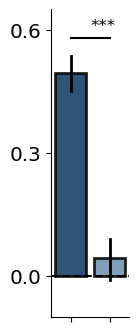

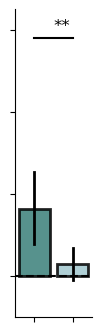

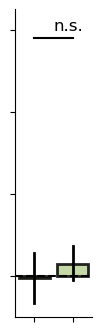

In [16]:
for i,M in enumerate(ORDER):
    fig,axes=plt.subplots(1,1,figsize=(1,4))
    temp=runwise_sim[(runwise_sim['session_type']==M)]
    g=sns.barplot(ax=axes, data=temp, x='simulated', y='delta_BC', 
                  palette=[colors_main[M], colors_sim[M]],edgecolor="k",errcolor="black",
                errwidth=2, alpha=0.85,)
    axes.axhline(0, ls='--', c='k') 
    ysim=temp[temp['simulated']==True]['delta_BC'].values
    yobs=temp[temp['simulated']==False]['delta_BC'].values
    
    if i == 0:
        g.set(ylim=[-0.1, 0.65],  xticklabels=['',""], yticks=[0,0.3,0.6], xlabel='', ylabel='')
    else:
        g.set(ylim=[-0.1, 0.65],  xticklabels=['',""], yticklabels=[], xlabel='',ylabel='')
    
    _,p=ttest_ind(yobs,ysim,permutations=10000,alternative='greater')
    _,p1=ttest_1samp(ysim,popmean=0,alternative='two-sided')
    symb = determine_symbol(p)
    # check statistics w bootstrapping in R
    axes.axhline(y=0.58, xmin=0.25, xmax=0.75 , ls='-', c='k')
    axes.text(x=0.5,y=0.6,s=symb)
    sns.despine(right=True,top=True)
    plt.savefig(f'plots/true_v_sim_bars_{M}.pdf', transparent=True,bbox_inches = "tight",format='pdf')

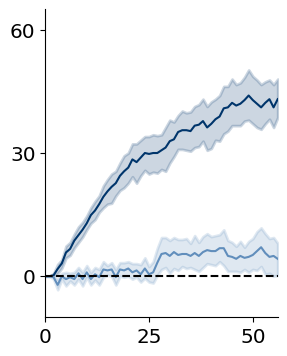

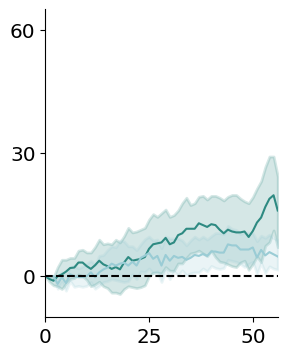

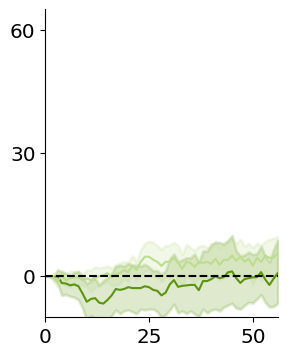

In [11]:
maxx=56
for M in ORDER:
    fig,ax=plt.subplots(1,1,figsize=(3, 4))
    df_here = trialwise_sim[(trialwise_sim['perturbation']==M)&(trialwise_sim['flattened_trials']>=0)&(trialwise_sim['flattened_trials']<=maxx)]
    hues={True: colors_sim[M], False: colors_main[M]}
    g=sns.lineplot(hue='simulated', x='flattened_trials', y='brain_control_normalized_perturb_start', data=df_here, palette=hues, legend=False)
    g.set(xlabel='', ylabel='',xlim=[0,maxx],xticks=np.arange(0,55,25),
      ylim=[-0.1,0.65],yticks=np.arange(0,0.65,0.3),yticklabels=[0, 30, 60])
    g.axhline(0, c='k',ls='--')
    sns.despine()
    plt.savefig(f'plots/behavioral_curves_{M}.pdf', transparent=True, bbox_inches = "tight",format='pdf')

In [12]:
def expand_pval_for_plot(is_cluster_mask, cluster_pv, num_trials):
    is_signif_mask = np.zeros(num_trials)
    pvalues = np.ones(num_trials)
    for slicee in is_cluster_mask:
        sl = slicee[0]
        is_signif_mask[sl] = 1
        pvalues[sl] *= cluster_pv[0]
    return is_signif_mask, pvalues

In [13]:
# get trialseries associated with IM 

pvalues_trialseries = {}
signif_mask_trialseries = {}
arr = np.empty((18,maxx+1,3))
for i,M in enumerate(ORDER):
    d = trialwise_results[trialwise_results['perturbation']==M]
    counter=0
    for s in d.subject_id.unique():
        if int(s.replace('avatarRT_sub_','')) in exclude_from_neural_analyses:
            continue
        sd = d[(d['subject_id']==s) & (d['flattened_trials']>=0) & (d['flattened_trials']<=maxx)]['brain_control_normalized_perturb_start'].values
        
        if sd.shape[0]<=maxx:
            to_pad = maxx+1 - sd.shape[0]
            sd=np.pad(sd, (0, to_pad), mode='edge')
            
        arr[counter, :,i]=sd
        counter+=1
    # now run test
    t_obs, is_cluster_mask, cluster_pv, H0_perm = permutation_cluster_1samp_test(arr[...,i], tail=1, n_permutations=10000,
                                                                                 threshold=2.5, max_step=4, adjacency=None, 
                                                                                 out_type='mask', buffer_size=None)
    is_signif_mask, pvalues = expand_pval_for_plot(is_cluster_mask, cluster_pv, maxx+1)
    pvalues_trialseries[M] = pvalues
    signif_mask_trialseries[M] = is_signif_mask



avatarRT_sub_05 (57,)
avatarRT_sub_06 (57,)
avatarRT_sub_07 (57,)
avatarRT_sub_08 (57,)
avatarRT_sub_10 (57,)
avatarRT_sub_11 (57,)
avatarRT_sub_13 (57,)
avatarRT_sub_14 (57,)
avatarRT_sub_15 (57,)
avatarRT_sub_16 (57,)
avatarRT_sub_17 (57,)
avatarRT_sub_18 (57,)
avatarRT_sub_19 (57,)
avatarRT_sub_21 (57,)
avatarRT_sub_22 (57,)
avatarRT_sub_23 (57,)
avatarRT_sub_24 (57,)
avatarRT_sub_25 (57,)
stat_fun(H1): min=nan max=nan
Running initial clustering …
Found 1 cluster


/gpfs/milgram/project/casey/elb77/conda_envs/rtcloud_av1/lib/python3.7/site-packages/mne/stats/parametric.py:55: RuntimeWarning: invalid value encountered in true_divide
  return np.mean(X, axis=0) / np.sqrt(var / X.shape[0])


  0%|          | Permuting : 0/9999 [00:00<?,       ?it/s]

avatarRT_sub_05 (56,)
avatarRT_sub_05 (57,)
avatarRT_sub_06 (57,)
avatarRT_sub_07 (52,)
avatarRT_sub_07 (57,)
avatarRT_sub_08 (50,)
avatarRT_sub_08 (57,)
avatarRT_sub_10 (50,)
avatarRT_sub_10 (57,)
avatarRT_sub_11 (57,)
avatarRT_sub_13 (57,)
avatarRT_sub_14 (57,)
avatarRT_sub_15 (57,)
avatarRT_sub_16 (57,)
avatarRT_sub_17 (57,)
avatarRT_sub_18 (57,)
avatarRT_sub_19 (57,)
avatarRT_sub_21 (57,)
avatarRT_sub_22 (57,)
avatarRT_sub_23 (57,)
avatarRT_sub_24 (51,)
avatarRT_sub_24 (57,)
avatarRT_sub_25 (57,)
stat_fun(H1): min=nan max=nan
Running initial clustering …
Found 3 clusters


  0%|          | Permuting : 0/9999 [00:00<?,       ?it/s]

avatarRT_sub_05 (31,)
avatarRT_sub_05 (57,)
avatarRT_sub_06 (50,)
avatarRT_sub_06 (57,)
avatarRT_sub_07 (55,)
avatarRT_sub_07 (57,)
avatarRT_sub_08 (53,)
avatarRT_sub_08 (57,)
avatarRT_sub_10 (55,)
avatarRT_sub_10 (57,)
avatarRT_sub_11 (57,)
avatarRT_sub_13 (57,)
avatarRT_sub_14 (56,)
avatarRT_sub_14 (57,)
avatarRT_sub_15 (57,)
avatarRT_sub_16 (56,)
avatarRT_sub_16 (57,)
avatarRT_sub_17 (57,)
avatarRT_sub_18 (57,)
avatarRT_sub_19 (57,)
avatarRT_sub_21 (57,)
avatarRT_sub_22 (57,)
avatarRT_sub_23 (57,)
avatarRT_sub_24 (57,)
avatarRT_sub_25 (57,)
stat_fun(H1): min=nan max=nan
Running initial clustering …
Found 0 clusters


/tmp/ipykernel_3264504/374020237.py:23: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  out_type='mask', buffer_size=None)


54 60
22 58
0 56


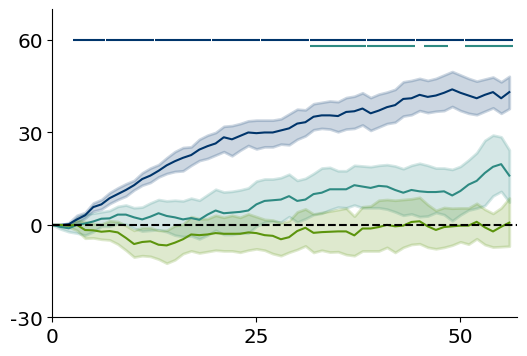

In [15]:
df_here = trialwise_results[trialwise_results['flattened_trials']>=0]
maxx=56
df_here=df_here[df_here['flattened_trials']<=maxx]
fig,ax=plt.subplots(1,1,figsize=(6,4))
g=sns.lineplot(hue='perturbation', x='flattened_trials', y='brain_control_normalized_perturb_start', 
               data=df_here, palette=colors_main, legend=False,ax=ax)
g.set(xlabel='', ylabel='',xlim=[0,maxx+1],xticks=np.arange(0,maxx+1,25),
      ylim=[-0.3,0.7],yticks=np.arange(-0.3,0.65,0.3),yticklabels=[-30, 0, 30, 60])
g.axhline(0, c='k',ls='--')

YVALS=[60,58,56]
for i,M in enumerate(ORDER):
    mask = pvalues_trialseries[M]#.astype(bool)
    mask = np.where(mask < 0.05, 1, 0).astype(bool)
    xaxis=np.arange(0,maxx+1)
    ax.scatter(x=xaxis[mask], y=np.repeat(YVALS[i]/100, np.sum(mask)), marker='_', s=40, c=colors_main[M])
    print(np.sum(mask),YVALS[i])
    
sns.despine()
plt.savefig('plots/behavioral_curves_signif.pdf', transparent=True,bbox_inches = "tight",format='pdf')

In [22]:
run_res = run_results[~run_results['subject_id'].isin(exclude_from_neural_analyses)]
make_barplot_points(run_results, 'delta_BC', 'session_type', exclude_subs=exclude_from_neural_analyses, ylim=[-0.3,0.7],
                    outfn='plots/behavioral_difference_true.pdf',
                    title='',plus_bot=0.2, plus_top=0.35, n_iter=10000, sample_alternative='two-sided',
                    pairwise_alternative='two-sided')

['avatarRT_sub_05', 'avatarRT_sub_06', 'avatarRT_sub_07', 'avatarRT_sub_08', 'avatarRT_sub_09', 'avatarRT_sub_10', 'avatarRT_sub_11', 'avatarRT_sub_12', 'avatarRT_sub_13', 'avatarRT_sub_14', 'avatarRT_sub_15', 'avatarRT_sub_16', 'avatarRT_sub_17', 'avatarRT_sub_18', 'avatarRT_sub_19', 'avatarRT_sub_20', 'avatarRT_sub_21', 'avatarRT_sub_22', 'avatarRT_sub_23', 'avatarRT_sub_24', 'avatarRT_sub_25']
IM 0.0, WM 0.0025, OM 0.8948
two-sided
IMvWM: 0.0002, IMvOM: 0.0002, WMvOM: 0.019
avatarRT_sub_09
avatarRT_sub_12
avatarRT_sub_20
